#1. Installation

In [7]:
%tensorflow_version 1.x
!pip install --upgrade h5py==2.10.0
!git clone https://github.com/pysource7/Mask_RCNN
import sys
sys.path.append("/content/Mask_RCNN/demo/")
from train_mask_rcnn_demo import *
%matplotlib inline


fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
VERS 0.2


Using TensorFlow backend.


... done downloading pretrained model!


In [8]:
!nvidia-smi

Thu Oct 21 12:33:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2. Image Dataset

In [9]:
# Extract Images
images_path = "images.zip"
annotations_path = "annotations.json"

extract_images(os.path.join("/content/", images_path), "/content/dataset")

Extracted: 8 images


In [13]:
dataset_train = load_image_dataset(os.path.join("/content/", annotations_path), "/content/dataset", "train")
dataset_val = load_image_dataset(os.path.join("/content/", annotations_path), "/content/dataset", "val")
print('Validation: %d' % len(dataset_val.image_ids))

class_number = dataset_train.count_classes()
print("Classes: {}".format(class_number))

Annotation json path:  /content/annotations.json
Annotation json path:  /content/annotations.json
Validation: 0
Classes: 1


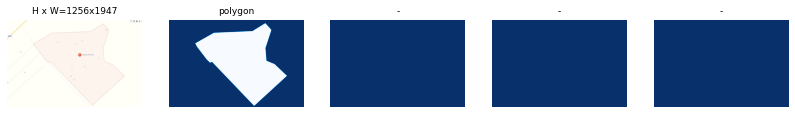

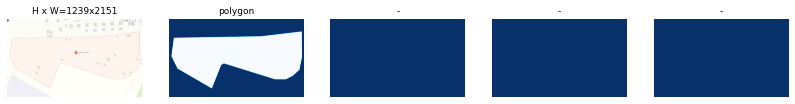

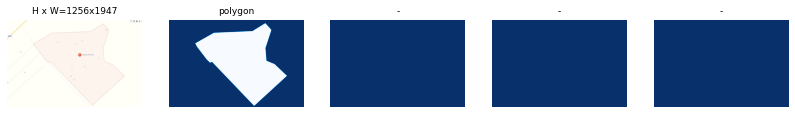

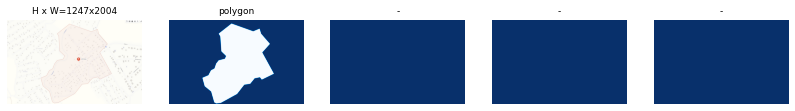

In [14]:
# Load image samples
display_image_samples(dataset_train)

In [15]:
# Load Configuration
config = CustomConfig(class_number)
#config.display()
model = load_training_model(config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
/content/Mask_RCNN/mask_rcnn_coco.h5


# 3. Training

Train Mask RCNN on your custom Dataset

In [ ]:
# Start Training
# This operation might take a long time
train_head(model, dataset_train, dataset_train, config)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/object20211021T1307/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn

# 4. Detection (test your model on a random image)

In [ ]:
# Load Test Model
# The latest trained model will be loaded
test_model, inference_config = load_test_model(class_number)

In [ ]:
# Test on a random image
test_random_image(test_model, dataset_val, inference_config)